# Geonames modifications

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

## Read the CSV file into a pandas dataframe

In [20]:
modifications = pd.read_csv('D:/Geonames/geonames_0.csv', delimiter=',', low_memory=False)
modifications.head()

,OBJECTID,GeonamesId,Name,ModificationDate,GlobalID,CreationDate,Creator,EditDate,Editor,CountryCode,x,y
0,2328,1821095,Nanhua Jiao,3/25/2018 12:00:00 AM,1fdd7ac5-c034-4edc-b81d-5c307c0c1c1e,3/26/2018 6:00:02 AM,NaN,3/26/2018 6:00:02 AM,NaN,CN,114.18415,8.71587
1,2329,1821242,Banyue Jiao,3/25/2018 12:00:00 AM,292c65ee-d2b9-4c8a-a15a-c260f7ff0551,3/26/2018 6:00:02 AM,NaN,3/26/2018 6:00:02 AM,NaN,CN,116.28664,8.91340
2,2330,11055130,Holý vrch [Břasy - Vranovice],3/25/2018 12:00:00 AM,1f46e4a9-77b4-40b2-89bf-1a846c8a838b,3/26/2018 6:00:02 AM,NaN,3/26/2018 6:00:02 AM,NaN,CZ,13.54238,49.85081
3,2331,11055135,Bechlov [Drahoňův Újezd],3/25/2018 12:00:00 AM,f6f8680e-bdf0-412c-95b1-8dab7e11e8df,3/26/2018 6:00:02 AM,NaN,3/26/2018 6:00:02 AM,NaN,CZ,13.68107,49.85288
4,2332,11055151,Chlum [Plzeň - Doubravka],3/25/2018 12:00:00 AM,ce2753c9-7968-451a-9b3f-ff4fb41cac66,3/26/2018 6:00:02 AM,NaN,3/26/2018 6:00:02 AM,NaN,CZ,13.43008,49.76755


## Create a simple histogram using the modification date

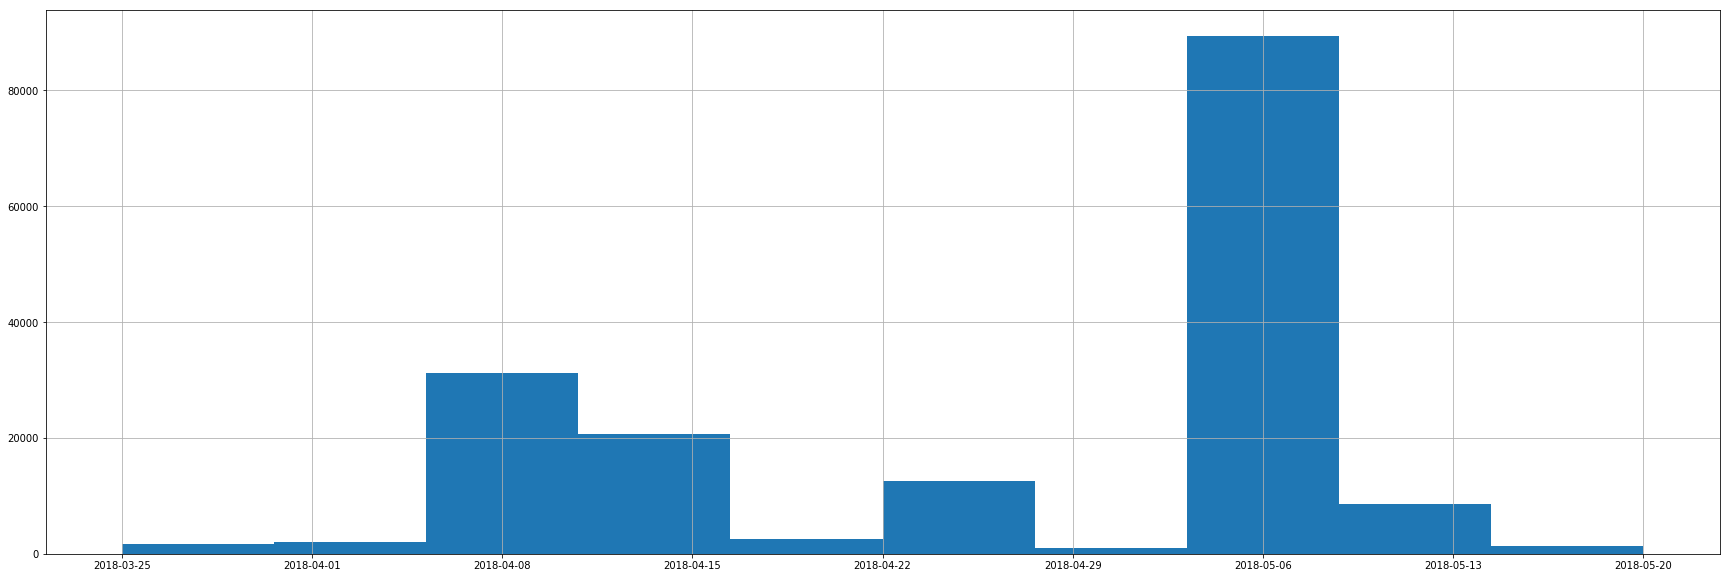

In [22]:
dates = pd.to_datetime(modifications['ModificationDate'])
plt.rcParams['figure.figsize'] = (30, 10)
dates.hist()